In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, recall_score, f1_score, precision_score
from matplotlib import pyplot as  plt
import concurrent.futures
import warnings
warnings.filterwarnings('ignore')

In [2]:
def generate_data():
    """
    This function is to generate dataset for cross validation with 25% data available
    """
    df = pd.read_excel('HW_TESLA.xlt')
    le=LabelEncoder().fit_transform(df['STATIC'])
    df_train, df_test = train_test_split(df, test_size=0.25) # 75 % training data
    #Separating feature matrix and corresponding labels
    X_train = df_train.drop('STATIC',axis=1)
    X_test = df_test.drop('STATIC',axis=1)
    y_train = df_train['STATIC']
    y_test = df_test['STATIC']
    return X_train, y_train, X_test, y_test

In [3]:
def generate_report(conf_mat, y_test, y_pred):

    FP = conf_mat[0][1]
    FN = conf_mat[1][0]
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1score = f1_score(y_test, y_pred)

    return FP, FN, accuracy, recall, precision, f1score

### Generating Dataset 

In [4]:
X_train, y_train, X_test, y_test = generate_data()

### Applying Decision Tree before PCA 

In [17]:
def DT_before_PCA():
    
    p_grid = {'criterion': ['gini','entropy'],
                   'max_depth': [2,3,4,5,6,7],
                   'min_samples_split':[2,3,4,5,10,20,50],
                   }
    clf = DecisionTreeClassifier()
    clf_random = GridSearchCV(estimator=clf, param_grid=p_grid,
                             cv = 3, n_jobs = -1, scoring='recall')
    clf_random.fit(X_train, y_train)
    #     cv = ShuffleSplit(n_splits=10, test_size=0.33, random_state=0)
    scores = cross_val_score(clf_random, X_train, y_train, cv=3)
    val_score = (scores.mean(), scores.std() * 2)

    y_pred = clf_random.predict(X_test)
    conf_mat=confusion_matrix(y_test,y_pred)
    outcome = list(generate_report(conf_mat, y_test, y_pred))
    outcome.insert(0, val_score[0])
#     print(clf_random.best_estimator_)
    return outcome

In [18]:
DT_before_PCA()

[0.9937164512636211,
 3,
 4,
 0.9932562620423893,
 0.9933774834437086,
 0.9950248756218906,
 0.9942004971002485]

### Calculating n_components in PCA for feature reduction

[ 51.8  90.2  97.8  99.7 100.  100.  100.  100.  100.  100.  100.  100.
 100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.
 100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.
 100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.
 100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.
 100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.
 100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.
 100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.
 100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.
 100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.
 100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100. ]


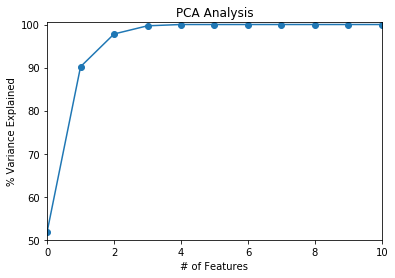

In [7]:
#Centering data by mean i.e. subtracting mean from each data and doing PCA
# X_train, y_train, X_test, y_test = generate_data()
scaler=StandardScaler().fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)


covar_matrix=PCA()
covar_matrix.fit(X_train)
variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios
var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)
print(var) #cumulative sum of variance explained with [n] features

plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.ylim(50,100.5)
plt.xlim(0,10)
plt.style.context('seaborn-whitegrid')


plt.plot(var, marker='o')

In [8]:
def apply_PCA(X_train, X_test):
    # we can reduce number of features to 5 to capture 99.8 % variance in PCA
    pca=PCA(n_components=5)
    pca.fit(X_train)

    # Get new feature matrices from pca
    pca_X_train=pca.transform(X_train)
    pca_X_test=pca.transform(X_test)
    return pca_X_train, pca_X_test

In [9]:
pca_X_train, pca_X_test = apply_PCA(X_train, X_test)

### Running Decision Tree Algorithm after PCA

In [14]:
def DT_after_PCA():
    scoring = ['accuracy', 'recall']
#     X_train, y_train, X_test, y_test = generate_data()
#     pca_X_train, pca_X_test = apply_PCA(X_train, X_test)
    

    p_grid = {'criterion': ['gini','entropy'],
               'max_depth': [2,3,4,5,6,7,8,9],
               'min_samples_split':[2,3,4,5],
               }

    clf = DecisionTreeClassifier()
    clf_gs = GridSearchCV(estimator=clf, param_grid=p_grid,
                                cv = 3, n_jobs = -1, scoring=scoring, refit='recall')
    clf_gs.fit(X_train, y_train)
    scores = cross_val_score(clf_gs, X_train, y_train, cv=3)
    val_score = (scores.mean(), scores.std() * 2)

    y_pred = clf_gs.predict(X_test)
    conf_mat=confusion_matrix(y_test,y_pred)
    outcome = list(generate_report(conf_mat, y_test, y_pred))
    outcome.insert(0, val_score[0])
#     print(clf_gs.best_estimator_)

    return outcome

In [15]:
DT_after_PCA()

[0.9937180968178273,
 2,
 5,
 0.9932562620423893,
 0.9917218543046358,
 0.9966722129783694,
 0.9941908713692946]

### Running Logistic Regression after PCA

In [19]:
def LR_after_PCA():
#     X_train, y_train, X_test, y_test = generate_data()
#     pca_X_train, pca_X_test = apply_PCA(X_train, X_test)

    scoring = ['accuracy', 'f1']
    random_grid = {'solver' : ['newton-cg','lbfgs', 'liblinear', 'sag', 'saga'],
                   'C' : [.1,.2,.3,.4,.5,.6,.7,.8,.9,1],
                   'max_iter':[100,200,300],
                   
                  }
    
    clf = LogisticRegression()
    clf_random = GridSearchCV(estimator=clf, param_grid=random_grid,
                             cv = 3, n_jobs = -1, scoring=scoring, refit='f1')
    clf_random.fit(pca_X_train,y_train)

    # Trying ShuffleSplit
#     cv = ShuffleSplit(n_splits=10, test_size=0.33, random_state=0)
    scores = cross_val_score(clf_random, pca_X_train, y_train, cv=5)
#     print("cross_val_score Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

    y_pred = clf_random.predict(pca_X_test)
    conf_mat=confusion_matrix(y_test,y_pred)
    
    outcome = list(generate_report(conf_mat, y_test, y_pred))
    outcome.insert(0, scores[0])
#     print(clf_random.best_estimator_)
    return outcome

In [20]:
LR_after_PCA()

[0.9921052631578947,
 0,
 5,
 0.9951830443159922,
 0.9917218543046358,
 1.0,
 0.9958437240232751]

### Running Linear SVM after PCA

In [24]:
def SVM_after_PCA():
#     start = time.perf_counter()
#     X_train, y_train, X_test, y_test = generate_data()
    
#     p_grid = {
#                    'C' : [.2, .3, .4, .5, .6, .7, .8, .9, 1],
#                   'kernel': ['linear','poly','rbf','sigmoid'],
#                   'degree': [2,3,4],
#                   'gamma': ['scale','auto'],
#                   'decision_function_shape': ['ovo','ovr'],
#                   }
    p_grid = {
                   'C' : [.2, .3, .4, .5, .6, .7, .8, .9, 1],
                  'kernel': ['linear','poly','rbf','sigmoid'],
                  }
    
    clf = SVC()
    clf_random = RandomizedSearchCV(estimator=clf, param_distributions=p_grid, 
                                    n_iter = 100, cv = 3, random_state=42, 
                                    n_jobs = -1, scoring='f1')
#     clf_gs = GridSearchCV(estimator=clf, param_grid=p_grid, 
#                                     cv = 3, n_jobs = -1, scoring='f1')
    clf_random.fit(pca_X_train,y_train)

    # Trying ShuffleSplit
#     cv = ShuffleSplit(n_splits=10, test_size=0.33, random_state=0)
    scores = cross_val_score(clf_random, pca_X_train, y_train, cv=3)
#     print("cross_val_score Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

    y_pred = clf_random.predict(pca_X_test)
    conf_mat=confusion_matrix(y_test,y_pred)
    
    outcome = list(generate_report(conf_mat, y_test, y_pred))
    outcome.insert(0, scores[0])
    
    return outcome
    

In [22]:
SVM_after_PCA()

[0.9952830188679246,
 2,
 5,
 0.9932562620423893,
 0.9917218543046358,
 0.9966722129783694,
 0.9941908713692946]

In [ ]:
def RF_after_PCA():
        
    n_estimators = [int(x) for x in np.linspace(start = 10, stop = 50, num = 5)]
    max_features = ['auto', 'sqrt']
    max_depth = list(range(1,10,1))
    max_depth.append(None)
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    bootstrap = [True, False]
    random_grid = {'n_estimators': n_estimators,
                   'max_depth': max_depth,
                   'min_samples_split':min_samples_split,
                   'bootstrap': bootstrap}
    
    clf = RandomForestClassifier()
    clf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, 
                                  n_iter = 100, cv = 3, random_state=42, n_jobs = -1)
    
    clf_random.fit(pca_X_train,y_train)
    
    # Trying ShuffleSplit
#     cv = ShuffleSplit(n_splits=10, test_size=0.33, random_state=0)
    scores = cross_val_score(clf_random, pca_X_train, y_train, cv=3)
#     print("cross_val_score Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

    y_pred = clf_random.predict(pca_X_test)
    conf_mat=confusion_matrix(y_test,y_pred)
    
    outcome = list(generate_report(conf_mat, y_test, y_pred))
    outcome.insert(0, scores[0])
    print(clf_random.best_params_)
#     print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))
    return outcome

In [ ]:
RF_after_PCA()

### Getting the report of different algorithms

In [33]:
import sys
import tqdm
# global X_train,X_test, y_train, y_test, pca_X_train, pca_X_test


algos = {'Decision Tree before PCA':DT_before_PCA,
         'Decision Tree with PCA':DT_after_PCA,
         'Logistic Regression':LR_after_PCA,
         'SVM':SVM_after_PCA}
# print('Modelling in progress', end='...')
for k in tqdm.tqdm(algos.keys()):
    count = 10 # Experiment Count for analysis
    algo = algos[k]
    start = time.perf_counter()
    val_scores = np.array([])
    p_scores = np.array([])
    measurements = []

    for _ in tqdm.tqdm(range(count)):
        X_train, y_train, X_test, y_test = generate_data()        
        pca_X_train, pca_X_test = apply_PCA(X_train, X_test)
        outcome = algo()
        measurements.append(outcome)
   
  
#     with concurrent.futures.ProcessPoolExecutor() as executor:
#         results = [executor.submit(algo) for _ in range(count)]

#     for f in concurrent.futures.as_completed(results):
#         outcome = f.result()
#         measurements.append(outcome)

    print("\n\n\nRan the experiment with", k , count, "times")
    print("Report: \n")
    cols = ['Val_Accuracy', 'FP', 'FN', 'Accuracy', 'Recall', 'Precision', 'F1Score']
    df_outcome = pd.DataFrame(measurements, columns=cols)
    print(df_outcome)

    finish = time.perf_counter()
    print("Averaging the above experiments: \n")
    print(df_outcome.mean())
    print("Time Taken for execution is ", round(finish-start, 2), 'Seconds')









  0%|          | 0/4 [00:00<?, ?it/s]








  0%|          | 0/10 [00:00<?, ?it/s]








 10%|█         | 1/10 [00:11<01:43, 11.50s/it]








 20%|██        | 2/10 [00:21<01:29, 11.14s/it]

KeyboardInterrupt: 